In [10]:
from transformer_lens import HookedEncoderDecoder
import transformer_lens.utils as utils
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformer_lens.loading_from_pretrained import OFFICIAL_MODEL_NAMES


from tqdm import tqdm
import json
from collections import defaultdict
from os import makedirs
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import torch 
torch.set_grad_enabled(False)

# For notebook usage - hardcode paths instead of using argparse
# checkpoint = "/home/ghoummaid/genir/trained_models/wikipedia_prefix/32/checkpoint-227000"
# checkpoint = "/home/ghoummaid/genir/trainer_output/checkpoint-91000"
checkpoint = "/home/ghoummaid/genir/trained_models/wikipedia_prefix/32/t5-large/checkpoint-189000"
correct_valid_path = f"{checkpoint}/correct_valid.json"
val_queries_path = f"/home/ghoummaid/genir/anja_code/NQ10k/val_queries-10000-7423.json"
output_path = f"/home/ghoummaid/genir/analysis_results/cross_attention"

# Load Model and Data
OFFICIAL_MODEL_NAMES.append(checkpoint)

hf_model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
device = utils.get_device()
model = HookedEncoderDecoder.from_pretrained(checkpoint, hf_model=hf_model, device=device)

def get_tokens(text, pad=None):
    if not pad:
        return tokenizer(text, return_tensors='pt')['input_ids']
    else:
        return tokenizer(text, return_tensors='pt', padding='max_length', max_length=pad)['input_ids']

def process_resid(resid, model):
    decoder_resid = model.decoder_final_ln(resid)

    if model.cfg.tie_word_embeddings:
        # Rescale output before projecting on vocab
        # See https://github.com/tensorflow/mesh/blob/fa19d69eafc9a482aff0b59ddd96b025c0cb207d/mesh_tensorflow/transformer/transformer.py#L586
        decoder_resid *= model.cfg.d_model**-0.5

    return decoder_resid

def logit_lens_decoder(resid, model):
    decoder_resid = process_resid(resid, model=model)
    logits = model.unembed(decoder_resid)
    return logits

def preprocess_text(text):
    """Clean and normalize text for comparison"""
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    return text.split()

def get_title_tokens(title, tokenizer):
    """Get all token representations of title words in order"""
    title_words = preprocess_text(title)
    title_tokens = []  # Keep as list to preserve order
    
    for word in title_words:
        # Get tokens for the word as is
        tokens = tokenizer.encode(word, add_special_tokens=False)
        title_tokens.extend(tokens)  # Use extend to add tokens to flat list
        
        # # Also try with space prefix (common in tokenizers)
        # tokens_with_space = tokenizer.encode(' ' + word, add_special_tokens=False)
        # title_tokens.extend(tokens_with_space)
    
    return title_tokens

def calculate_title_overlap(top_tokens, title_tokens, tokenizer):
    """Calculate how many top tokens correspond to title words"""
    overlap_count = 0
    overlapping_tokens = []
    
    for token_id in top_tokens:
        if token_id in title_tokens:
            overlap_count += 1
            overlapping_tokens.append({
                'token_id': token_id,
                'token_text': tokenizer.decode([token_id])
            })
    
    return overlap_count, overlapping_tokens

# Add these imports to the first cell
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import difflib

# Load sentence transformer for semantic similarity
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

def get_word_embeddings(words, model):
    """Get embeddings for a list of words"""
    return model.encode(words)

def calculate_semantic_similarity(word1, word2, model, threshold=0.7):
    """Calculate semantic similarity between two words"""
    embeddings = model.encode([word1, word2])
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    return similarity >= threshold, similarity

def calculate_string_similarity(word1, word2, threshold=0.8):
    """Calculate string similarity using difflib"""
    similarity = difflib.SequenceMatcher(None, word1.lower(), word2.lower()).ratio()
    return similarity >= threshold, similarity
def enhanced_title_analysis(top_tokens, title_tokens, title_words, tokenizer, similarity_model, k, current_step, query_tokens=None, query_words=None):
    """
    Enhanced analysis for current generation step including query token analysis
    Args:
        top_tokens: top-k most likely tokens at current step
        title_tokens: flat list of all title token IDs in order
        title_words: list of title words in order
        tokenizer: tokenizer
        similarity_model: sentence transformer model
        k: number of top tokens
        current_step: current generation step (0-indexed)
        query_tokens: flat list of all query token IDs (optional)
        query_words: list of query words (optional)
    """
    results = {
        'exact_match_at_step': {
            'found': False,
            'token_id': None,
            'token_text': None,
            'rank_in_topk': None
        },
        'title_tokens_in_topk': {
            'count': 0,
            'ratio': 0.0,
            'tokens': []  # [(token_id, token_text, rank)]
        },
        'semantic_matches': {
            'count': 0,
            'matches': []  # [(token_id, token_text, similarity_score, rank)]
        },
        # NEW: Query token analysis
        'query_tokens_in_topk': {
            'count': 0,
            'ratio': 0.0,
            'tokens': []  # [(token_id, token_text, rank)]
        },
        'query_semantic_matches': {
            'count': 0,
            'matches': []  # [(token_id, token_text, similarity_score, rank, matched_query_word)]
        },
        'stats': {
            'exact_match_at_step': 0,  # 1 if exact match found, 0 otherwise
            'title_tokens_ratio': 0.0,
            'semantic_matches_ratio': 0.0,
            'query_tokens_ratio': 0.0,  # NEW
            'query_semantic_matches_ratio': 0.0  # NEW
        }
    }
    
    # Get the expected token at current step from title
    title_words_list = list(title_words)
    expected_word = None
    expected_tokens = set()
    
    if current_step < len(title_words_list):
        expected_word = title_words_list[current_step]
        # Get all possible tokenizations of the expected word
        expected_tokens.update(tokenizer.encode(expected_word, add_special_tokens=False))
        expected_tokens.update(tokenizer.encode(' ' + expected_word, add_special_tokens=False))
    
    # Convert top tokens to text for analysis
    top_token_texts = [tokenizer.decode([token_id]).strip() for token_id in top_tokens]
    
    # 1. Check for exact match at current step
    if expected_tokens:
        for rank, token_id in enumerate(top_tokens):
            if token_id in expected_tokens:
                results['exact_match_at_step']['found'] = True
                results['exact_match_at_step']['token_id'] = token_id
                results['exact_match_at_step']['token_text'] = tokenizer.decode([token_id])
                results['exact_match_at_step']['rank_in_topk'] = rank
                results['stats']['exact_match_at_step'] = 1
                break
    
    # 2. Check how many title tokens appear in top-k
    title_tokens_set = set(title_tokens)  # Convert to set for efficient lookup
    title_tokens_found = []
    for rank, token_id in enumerate(top_tokens):
        if token_id in title_tokens_set:
            title_tokens_found.append((token_id, tokenizer.decode([token_id]), rank))
    
    results['title_tokens_in_topk']['count'] = len(title_tokens_found)
    results['title_tokens_in_topk']['ratio'] = len(title_tokens_found) / k if k > 0 else 0
    results['title_tokens_in_topk']['tokens'] = title_tokens_found
    results['stats']['title_tokens_ratio'] = results['title_tokens_in_topk']['ratio']
    
    # 3. Check for semantic similarity to expected word at current step
    semantic_matches = []
    if expected_word:
        for rank, (token_id, token_text) in enumerate(zip(top_tokens, top_token_texts)):
            try:
                is_similar, similarity_score = calculate_semantic_similarity(
                    expected_word, token_text, similarity_model, threshold=0.7
                )
                if is_similar:
                    semantic_matches.append((token_id, token_text, similarity_score, rank))
            except:
                # Skip if similarity calculation fails
                continue
    
    results['semantic_matches']['count'] = len(semantic_matches)
    results['semantic_matches']['matches'] = semantic_matches
    results['stats']['semantic_matches_ratio'] = len(semantic_matches) / k if k > 0 else 0
    
    # 4. NEW: Check how many query tokens appear in top-k
    if query_tokens:
        query_tokens_set = set(query_tokens)
        query_tokens_found = []
        for rank, token_id in enumerate(top_tokens):
            if token_id in query_tokens_set:
                query_tokens_found.append((token_id, tokenizer.decode([token_id]), rank))
        
        results['query_tokens_in_topk']['count'] = len(query_tokens_found)
        results['query_tokens_in_topk']['ratio'] = len(query_tokens_found) / k if k > 0 else 0
        results['query_tokens_in_topk']['tokens'] = query_tokens_found
        results['stats']['query_tokens_ratio'] = results['query_tokens_in_topk']['ratio']
    
    # 5. NEW: Check for semantic similarity to query words
    query_semantic_matches = []
    if query_words:
        for rank, (token_id, token_text) in enumerate(zip(top_tokens, top_token_texts)):
            for query_word in query_words:
                try:
                    is_similar, similarity_score = calculate_semantic_similarity(
                        query_word, token_text, similarity_model, threshold=0.7
                    )
                    if is_similar:
                        query_semantic_matches.append((token_id, token_text, similarity_score, rank, query_word))
                        break  # Only count each token once, for the first matching query word
                except:
                    # Skip if similarity calculation fails
                    continue
    
    results['query_semantic_matches']['count'] = len(query_semantic_matches)
    results['query_semantic_matches']['matches'] = query_semantic_matches
    results['stats']['query_semantic_matches_ratio'] = len(query_semantic_matches) / k if k > 0 else 0
    
    return results
# def enhanced_title_analysis(top_tokens, title_tokens, title_words, tokenizer, similarity_model, k, current_step, query_tokens=None, query_words=None):
#     """
#     Enhanced analysis for current generation step
#     Args:
#         top_tokens: top-k most likely tokens at current step
#         title_tokens: flat list of all title token IDs in order
#         title_words: list of title words in order
#         tokenizer: tokenizer
#         similarity_model: sentence transformer model
#         k: number of top tokens
#         current_step: current generation step (0-indexed)
#     """
#     results = {
#         'exact_match_at_step': {
#             'found': False,
#             'token_id': None,
#             'token_text': None,
#             'rank_in_topk': None
#         },
#         'title_tokens_in_topk': {
#             'count': 0,
#             'ratio': 0.0,
#             'tokens': []  # [(token_id, token_text, rank)]
#         },
#         'semantic_matches': {
#             'count': 0,
#             'matches': []  # [(token_id, token_text, similarity_score, rank)]
#         },
#         'stats': {
#             'exact_match_at_step': 0,  # 1 if exact match found, 0 otherwise
#             'title_tokens_ratio': 0.0,
#             'semantic_matches_ratio': 0.0
#         }
#     }
    
#     # Get the expected token at current step from title
#     title_words_list = list(title_words)
#     expected_word = None
#     expected_tokens = set()
    
#     if current_step < len(title_words_list):
#         expected_word = title_words_list[current_step]
#         # Get all possible tokenizations of the expected word
#         expected_tokens.update(tokenizer.encode(expected_word, add_special_tokens=False))
#         expected_tokens.update(tokenizer.encode(' ' + expected_word, add_special_tokens=False))
    
#     # Convert top tokens to text for analysis
#     top_token_texts = [tokenizer.decode([token_id]).strip() for token_id in top_tokens]
    
#     # 1. Check for exact match at current step
#     if expected_tokens:
#         for rank, token_id in enumerate(top_tokens):
#             if token_id in expected_tokens:
#                 results['exact_match_at_step']['found'] = True
#                 results['exact_match_at_step']['token_id'] = token_id
#                 results['exact_match_at_step']['token_text'] = tokenizer.decode([token_id])
#                 results['exact_match_at_step']['rank_in_topk'] = rank
#                 results['stats']['exact_match_at_step'] = 1
#                 break
    
#     # 2. Check how many title tokens appear in top-k
#     title_tokens_set = set(title_tokens)  # Convert to set for efficient lookup
#     title_tokens_found = []
#     for rank, token_id in enumerate(top_tokens):
#         if token_id in title_tokens_set:
#             title_tokens_found.append((token_id, tokenizer.decode([token_id]), rank))
    
#     results['title_tokens_in_topk']['count'] = len(title_tokens_found)
#     results['title_tokens_in_topk']['ratio'] = len(title_tokens_found) / k if k > 0 else 0
#     results['title_tokens_in_topk']['tokens'] = title_tokens_found
#     results['stats']['title_tokens_ratio'] = results['title_tokens_in_topk']['ratio']
    
#     # 3. Check for semantic similarity to expected word at current step
#     semantic_matches = []
#     if expected_word:
#         for rank, (token_id, token_text) in enumerate(zip(top_tokens, top_token_texts)):
#             try:
#                 is_similar, similarity_score = calculate_semantic_similarity(
#                     expected_word, token_text, similarity_model, threshold=0.7
#                 )
#                 if is_similar:
#                     semantic_matches.append((token_id, token_text, similarity_score, rank))
#             except:
#                 # Skip if similarity calculation fails
#                 continue
    
#     results['semantic_matches']['count'] = len(semantic_matches)
#     results['semantic_matches']['matches'] = semantic_matches
#     results['stats']['semantic_matches_ratio'] = len(semantic_matches) / k if k > 0 else 0
    
#     # 4. NEW: Check how many query tokens appear in top-k
#     if query_tokens:
#         query_tokens_set = set(query_tokens)
#         query_tokens_found = []
#         for rank, token_id in enumerate(top_tokens):
#             if token_id in query_tokens_set:
#                 query_tokens_found.append((token_id, tokenizer.decode([token_id]), rank))
        
#         results['query_tokens_in_topk']['count'] = len(query_tokens_found)
#         results['query_tokens_in_topk']['ratio'] = len(query_tokens_found) / k if k > 0 else 0
#         results['query_tokens_in_topk']['tokens'] = query_tokens_found
#         results['stats']['query_tokens_ratio'] = results['query_tokens_in_topk']['ratio']
    
#     # 5. NEW: Check for semantic similarity to query words
#     query_semantic_matches = []
#     if query_words:
#         for rank, (token_id, token_text) in enumerate(zip(top_tokens, top_token_texts)):
#             for query_word in query_words:
#                 try:
#                     is_similar, similarity_score = calculate_semantic_similarity(
#                         query_word, token_text, similarity_model, threshold=0.7
#                     )
#                     if is_similar:
#                         query_semantic_matches.append((token_id, token_text, similarity_score, rank, query_word))
#                         break  # Only count each token once, for the first matching query word
#                 except:
#                     # Skip if similarity calculation fails
#                     continue
    
#     results['query_semantic_matches']['count'] = len(query_semantic_matches)
#     results['query_semantic_matches']['matches'] = query_semantic_matches
#     results['stats']['query_semantic_matches_ratio'] = len(query_semantic_matches) / k if k > 0 else 0

#     return results

If using T5 for interpretability research, keep in mind that T5 has some significant architectural differences to GPT. The major one is that T5 is an Encoder-Decoder modelAlso, it uses relative positional embeddings, different types of Attention (without bias) and LayerNorm


Loaded pretrained model /home/ghoummaid/genir/trained_models/wikipedia_prefix/32/t5-large/checkpoint-189000 into HookedTransformer


In [11]:
# Load eval data
correct_valid = json.load(open(correct_valid_path))
valid_queries = json.load(open(val_queries_path))

# Create mappings
q_id_to_q = {q['id']:q['query'] for q in valid_queries}
correct_queries_with_d_id = [(q, q_id_to_q[q], d) for d,q in correct_valid]
queries_with_d_id = [(q['id'], q['query'], "") for q in valid_queries]

print(f"Loaded {len(correct_queries_with_d_id)} query-document pairs")
print(f"Model has {model.cfg.n_layers} layers")

Loaded 21 query-document pairs
Model has 24 layers


In [12]:
# Modified main analysis cell
makedirs(output_path, exist_ok=True)

# Enhanced data collection structures with query metrics
enhanced_analysis_data = {
    'layer_stats': defaultdict(lambda: defaultdict(list)),
    'generation_step_stats': defaultdict(lambda: defaultdict(list)),
    'combined_stats': defaultdict(list),
    'detailed_per_query': [],
    'match_types': ['exact_match_at_step', 'title_tokens_ratio', 'semantic_matches_ratio', 'query_tokens_ratio', 'query_semantic_matches_ratio']
}

# Process subset for notebook
sample_size = min(50, len(correct_queries_with_d_id))
sample_queries = correct_queries_with_d_id[:sample_size]

for query_idx, (q_id, query, doc_id) in tqdm(enumerate(sample_queries), total=len(sample_queries)):
    input_tokens = get_tokens(query)
    
    # Get title tokens and words for comparison
    title_tokens = get_title_tokens(doc_id, tokenizer)
    title_words = preprocess_text(doc_id)
    
    # NEW: Get query tokens and words for comparison
    query_tokens = get_title_tokens(query, tokenizer)  # Reuse same function
    query_words = preprocess_text(query)
    
    if len(title_tokens) == 0 or len(title_words) == 0:
        continue
    
    query_data = {
        'query_id': q_id,
        'query': query,
        'query_words': list(query_words),
        'title': doc_id,
        'title_words': list(title_words),
        'generation_steps': []
    }

    decoder_input = torch.tensor([[0]])
    
    for step in range(len(list(title_words))):  # Don't exceed title length
        _, activation_cache = model.run_with_cache(input_tokens, decoder_input=decoder_input)
        
        step_data = {'step': step, 'layers': []}
        
        for layer in range(7, model.cfg.n_layers, 1):
            neuron_activations = activation_cache[f'decoder.{layer}.hook_cross_attn_out']
            value_logits = logit_lens_decoder(neuron_activations, model=model).cpu()
            topk_res = torch.topk(value_logits, k=100)
            
            layer_data = {'layer': layer, 'analysis_results': {}}
            
            # Analyze different top-k values
            for k in [10, 20, 50]:
                top_k_tokens = topk_res.indices[0][0][:k].tolist()
                
                # Enhanced analysis with current step and query information
                analysis_results = enhanced_title_analysis(
                    top_k_tokens, title_tokens, title_words, tokenizer, similarity_model, k, step,
                    query_tokens=query_tokens, query_words=query_words
                )
                
                layer_data['analysis_results'][f'top_{k}'] = analysis_results
                
                # Collect statistics
                layer_group = "early" if layer < model.cfg.n_layers//3 else "middle" if layer < 2*model.cfg.n_layers//3 else "late"
                
                for match_type in enhanced_analysis_data['match_types']:
                    ratio = analysis_results['stats'][match_type]
                    enhanced_analysis_data['layer_stats'][f'top_{k}_{match_type}'][f'{layer_group}_layers'].append(ratio)
                    enhanced_analysis_data['layer_stats'][f'top_{k}_{match_type}'][f'layer_{layer}'].append(ratio)
                    enhanced_analysis_data['generation_step_stats'][f'top_{k}_{match_type}'][f'step_{step}'].append(ratio)
                    enhanced_analysis_data['combined_stats'][f'top_{k}_{match_type}'].append(ratio)
            
            step_data['layers'].append(layer_data)
        
        query_data['generation_steps'].append(step_data)
        
        original_token = title_tokens[step]
        decoder_input = torch.cat([
            decoder_input,
            torch.tensor([[original_token]])
        ], dim=1)
    
    # Store examples for inspection
    if query_idx < 3:
        enhanced_analysis_data['detailed_per_query'].append(query_data)

print("Enhanced analysis with query token analysis complete!")

100%|██████████| 21/21 [1:40:59<00:00, 288.55s/it]

Enhanced analysis with query token analysis complete!


In [ ]:
# # Modified main analysis cell
# makedirs(output_path, exist_ok=True)

# # Enhanced data collection structures
# enhanced_analysis_data = {
#     'layer_stats': defaultdict(lambda: defaultdict(list)),
#     'generation_step_stats': defaultdict(lambda: defaultdict(list)),
#     'combined_stats': defaultdict(list),
#     'detailed_per_query': [],
#     'match_types': ['exact_match_at_step', 'title_tokens_ratio', 'semantic_matches_ratio']
# }

# # Process subset for notebook
# sample_size = min(50, len(correct_queries_with_d_id))
# sample_queries = correct_queries_with_d_id[:sample_size]

# for query_idx, (q_id, query, doc_id) in tqdm(enumerate(sample_queries), total=len(sample_queries)):
#     input_tokens = get_tokens(query)
    
#     # Get title tokens and words for comparison
#     title_tokens = get_title_tokens(doc_id, tokenizer)
#     title_words = preprocess_text(doc_id)
    
#     if len(title_tokens) == 0 or len(title_words) == 0:
#         continue
    
#     query_data = {
#         'query_id': q_id,
#         'query': query,
#         'title': doc_id,
#         'title_words': list(title_words),
#         'generation_steps': []
#     }

#     decoder_input = torch.tensor([[0]])
    
#     for step in range(len(list(title_words))):  # Don't exceed title length
#         _, activation_cache = model.run_with_cache(input_tokens, decoder_input=decoder_input)
        
#         step_data = {'step': step, 'layers': []}
        
#         for layer in range(7, model.cfg.n_layers, 1):
#             neuron_activations = activation_cache[f'decoder.{layer}.hook_cross_attn_out']
#             value_logits = logit_lens_decoder(neuron_activations, model=model).cpu()
#             topk_res = torch.topk(value_logits, k=100)
            
#             layer_data = {'layer': layer, 'analysis_results': {}}
            
#             # Analyze different top-k values
#             for k in [10, 20, 50]:
#                 top_k_tokens = topk_res.indices[0][0][:k].tolist()
                
#                 # Enhanced analysis with current step
#                 analysis_results = enhanced_title_analysis(
#                     top_k_tokens, title_tokens, title_words, tokenizer, similarity_model, k, step
#                 )
                
#                 layer_data['analysis_results'][f'top_{k}'] = analysis_results
                
#                 # Collect statistics
#                 layer_group = "early" if layer < model.cfg.n_layers//3 else "middle" if layer < 2*model.cfg.n_layers//3 else "late"
                
#                 for match_type in enhanced_analysis_data['match_types']:
#                     ratio = analysis_results['stats'][match_type]
#                     enhanced_analysis_data['layer_stats'][f'top_{k}_{match_type}'][f'{layer_group}_layers'].append(ratio)
#                     enhanced_analysis_data['layer_stats'][f'top_{k}_{match_type}'][f'layer_{layer}'].append(ratio)
#                     enhanced_analysis_data['generation_step_stats'][f'top_{k}_{match_type}'][f'step_{step}'].append(ratio)
#                     enhanced_analysis_data['combined_stats'][f'top_{k}_{match_type}'].append(ratio)
            
#             step_data['layers'].append(layer_data)
        
#         query_data['generation_steps'].append(step_data)
        
#         # Generate next token
#         # logits = model(input_tokens, decoder_input)[0, -1, :]
#         # next_token = logits.argmax().item()
        
#         # if next_token == tokenizer.eos_token_id:
#         #     break
        
#         original_token = title_tokens[step]
#         # assert next_token == original_token, f"Expected {original_token} but got {next_token} for query {query} and doc {doc_id} at step {step}"

#         decoder_input = torch.cat([
#             decoder_input,
#             torch.tensor([[original_token]])
#         ], dim=1)
    
#     # Store examples for inspection
#     if query_idx < 3:
#         enhanced_analysis_data['detailed_per_query'].append(query_data)

# print("Enhanced analysis complete!")

100%|██████████| 21/21 [10:46<00:00, 30.77s/it]

Enhanced analysis complete!


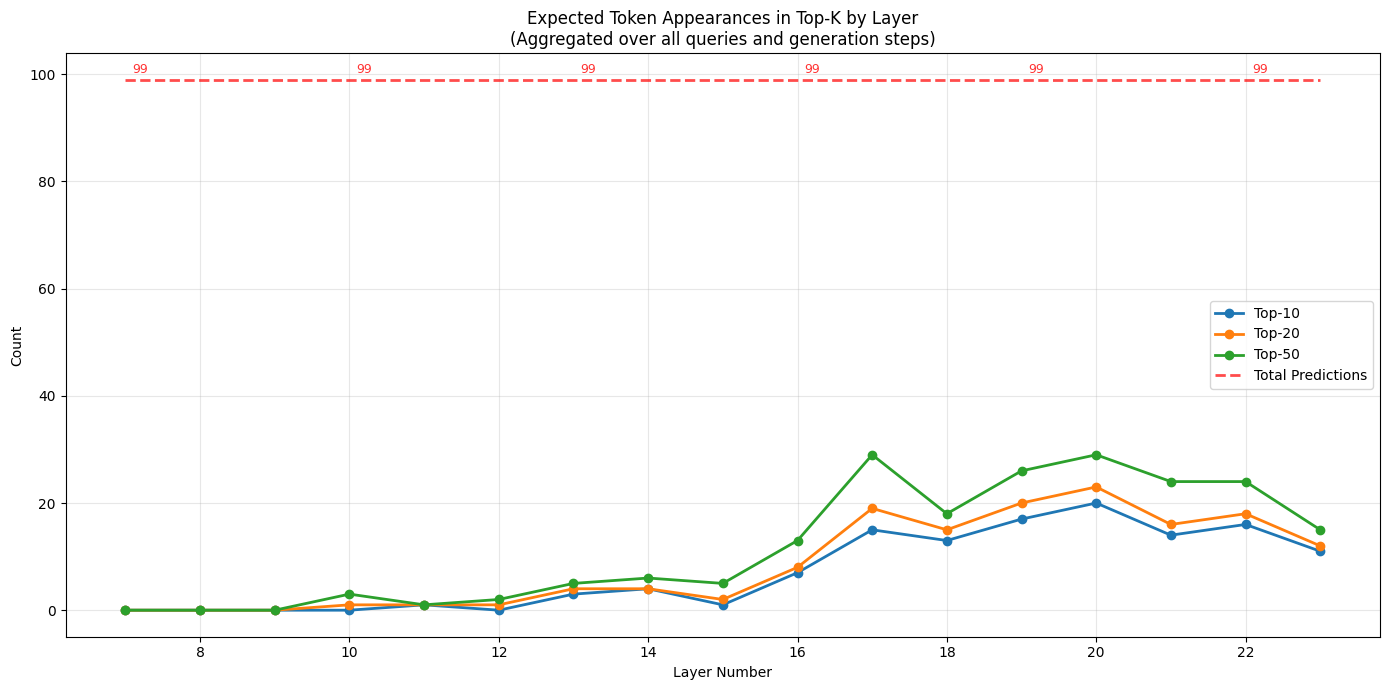

LAYER-BY-LAYER TOKEN APPEARANCE COUNTS:
Layer | Top-10 | Top-20 | Top-50 | Total Predictions |
------|--------|--------|--------|-------------------|
    7 |      0 |      0 |      0 |                99 |
    8 |      0 |      0 |      0 |                99 |
    9 |      0 |      0 |      0 |                99 |
   10 |      0 |      1 |      3 |                99 |
   11 |      1 |      1 |      1 |                99 |
   12 |      0 |      1 |      2 |                99 |
   13 |      3 |      4 |      5 |                99 |
   14 |      4 |      4 |      6 |                99 |
   15 |      1 |      2 |      5 |                99 |
   16 |      7 |      8 |     13 |                99 |
   17 |     15 |     19 |     29 |                99 |
   18 |     13 |     15 |     18 |                99 |
   19 |     17 |     20 |     26 |                99 |
   20 |     20 |     23 |     29 |                99 |
   21 |     14 |     16 |     24 |                99 |
   22 |     16 |     18 |

In [13]:
# Simple analysis: Count of expected token appearances by layer
def analyze_token_counts_by_layer(enhanced_analysis_data):
    """
    Count how many times the expected token appears in top-k for each layer
    Aggregated over all queries and generation steps
    """
    
    results = {}
    
    # For each layer, count appearances across all top-k values
    for layer in range(7, model.cfg.n_layers):
        layer_key = f'layer_{layer}'
        results[layer] = {}
        
        for k in [10, 20, 50]:
            stat_key = f'top_{k}_exact_match_at_step'
            
            if layer_key in enhanced_analysis_data['layer_stats'][stat_key]:
                matches = enhanced_analysis_data['layer_stats'][stat_key][layer_key]
                count = sum(matches)  # Total count of appearances
                total = len(matches)   # Total predictions made
            else:
                count = 0
                total = 0
            
            results[layer][f'top_{k}'] = {
                'count': count,
                'total': total
            }
    
    return results

# Run the analysis
layer_counts = analyze_token_counts_by_layer(enhanced_analysis_data)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

layers = list(range(7, model.cfg.n_layers))

# Plot token counts on primary y-axis
for k in [10, 20, 50]:
    counts = [layer_counts[layer][f'top_{k}']['count'] for layer in layers]
    ax.plot(layers, counts, marker='o', linewidth=2, markersize=6, label=f'Top-{k}')

# Plot total predictions on the same scale
totals = [layer_counts[layer]['top_10']['total'] for layer in layers]  # Same for all k values
ax.plot(layers, totals, 'r--', linewidth=2, alpha=0.7, label='Total Predictions')

ax.set_xlabel('Layer Number')
ax.set_ylabel('Count')
ax.set_title('Expected Token Appearances in Top-K by Layer\n(Aggregated over all queries and generation steps)')
ax.legend()
ax.grid(True, alpha=0.3)

# Add text annotations showing total predictions for some layers
for i, layer in enumerate(layers[::3]):  # Show every 3rd layer to avoid crowding
    total = layer_counts[layer]['top_10']['total']
    ax.annotate(f'{total}', 
                xy=(layer, total), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9, 
                color='red', 
                alpha=0.8)

plt.tight_layout()
plt.show()

# Print summary table with totals
print("LAYER-BY-LAYER TOKEN APPEARANCE COUNTS:")
print("Layer | Top-10 | Top-20 | Top-50 | Total Predictions |")
print("------|--------|--------|--------|-------------------|")

for layer in layers:
    top10_count = layer_counts[layer]['top_10']['count']
    top20_count = layer_counts[layer]['top_20']['count']
    top50_count = layer_counts[layer]['top_50']['count']
    total_preds = layer_counts[layer]['top_10']['total']
    
    print(f"{layer:5d} | {top10_count:6d} | {top20_count:6d} | {top50_count:6d} | {total_preds:17d} |")

# Overall totals
print(f"\nOVERALL TOTALS:")
for k in [10, 20, 50]:
    total_count = sum(layer_counts[layer][f'top_{k}']['count'] for layer in layers)
    total_predictions = sum(layer_counts[layer][f'top_{k}']['total'] for layer in layers)
    print(f"Top-{k}: {total_count:,} appearances out of {total_predictions:,} total predictions")

# Check if all layers have the same total predictions
all_totals = [layer_counts[layer]['top_10']['total'] for layer in layers]
if len(set(all_totals)) == 1:
    print(f"\nAll layers have the same number of predictions: {all_totals[0]}")
else:
    print(f"\nPredictions vary by layer - Min: {min(all_totals)}, Max: {max(all_totals)}")

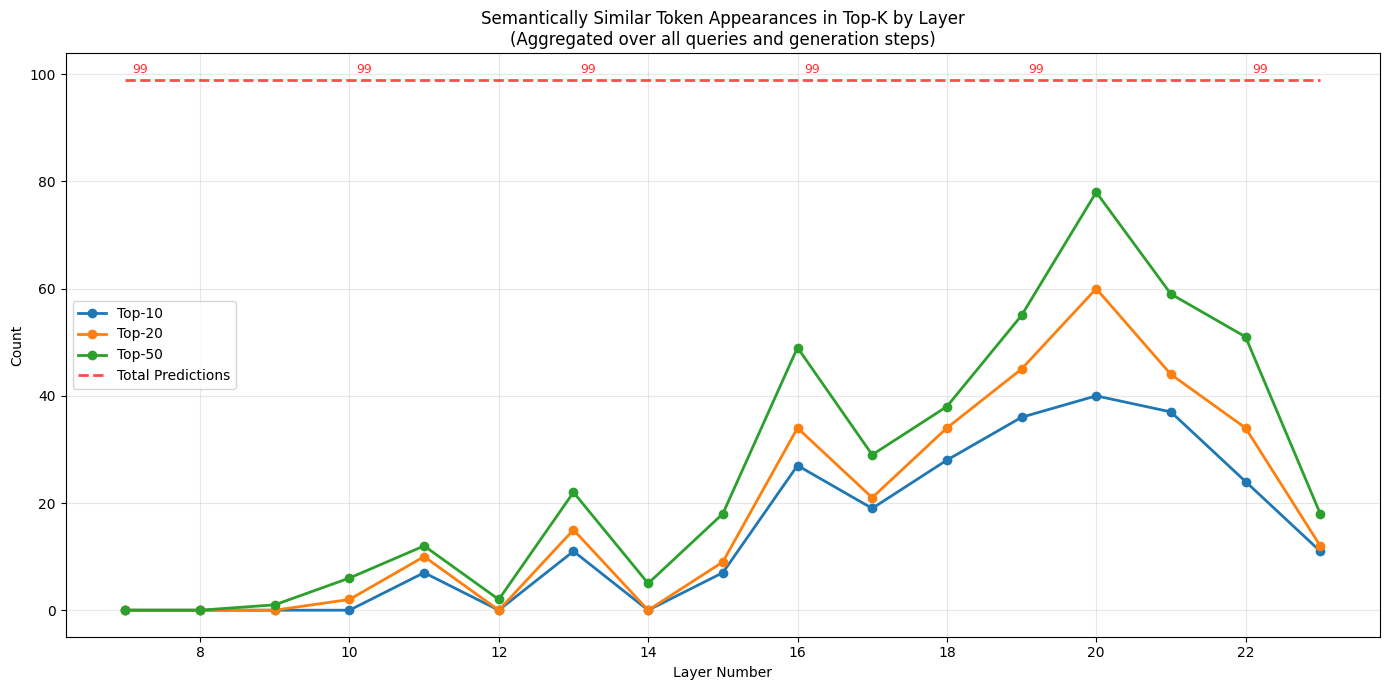

LAYER-BY-LAYER SEMANTIC SIMILARITY COUNTS:
Layer | Top-10 | Top-20 | Top-50 | Total Predictions |
------|--------|--------|--------|-------------------|
    7 |      0 |      0 |      0 |                99 |
    8 |      0 |      0 |      0 |                99 |
    9 |      0 |      0 |      1 |                99 |
   10 |      0 |      2 |      6 |                99 |
   11 |      7 |     10 |     12 |                99 |
   12 |      0 |      0 |      2 |                99 |
   13 |     11 |     15 |     22 |                99 |
   14 |      0 |      0 |      5 |                99 |
   15 |      7 |      9 |     18 |                99 |
   16 |     27 |     34 |     49 |                99 |
   17 |     19 |     21 |     29 |                99 |
   18 |     28 |     34 |     38 |                99 |
   19 |     36 |     45 |     55 |                99 |
   20 |     40 |     60 |     78 |                99 |
   21 |     37 |     44 |     59 |                99 |
   22 |     24 |     3

In [14]:
# Analysis for semantic similarity metric
def analyze_semantic_similarity_by_layer(enhanced_analysis_data):
    """
    Count how many times semantically similar tokens appear in top-k for each layer
    Aggregated over all queries and generation steps
    """
    
    results = {}
    
    # For each layer, count semantic matches across all top-k values
    for layer in range(7, model.cfg.n_layers):
        layer_key = f'layer_{layer}'
        results[layer] = {}
        
        for k in [10, 20, 50]:
            stat_key = f'top_{k}_semantic_matches_ratio'
            
            if layer_key in enhanced_analysis_data['layer_stats'][stat_key]:
                matches = enhanced_analysis_data['layer_stats'][stat_key][layer_key]
                # Convert ratios back to counts
                count = sum([ratio * k for ratio in matches])  # Total count of semantic matches
                total = len(matches)   # Total predictions made
            else:
                count = 0
                total = 0
            
            results[layer][f'top_{k}'] = {
                'count': int(count),  # Convert to int for cleaner display
                'total': total
            }
    
    return results

# Run the semantic similarity analysis
semantic_layer_counts = analyze_semantic_similarity_by_layer(enhanced_analysis_data)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

layers = list(range(7, model.cfg.n_layers))

# Plot semantic similarity counts
for k in [10, 20, 50]:
    counts = [semantic_layer_counts[layer][f'top_{k}']['count'] for layer in layers]
    ax.plot(layers, counts, marker='o', linewidth=2, markersize=6, label=f'Top-{k}')

# Plot total predictions on the same scale
totals = [semantic_layer_counts[layer]['top_10']['total'] for layer in layers]  # Same for all k values
ax.plot(layers, totals, 'r--', linewidth=2, alpha=0.7, label='Total Predictions')

ax.set_xlabel('Layer Number')
ax.set_ylabel('Count')
ax.set_title('Semantically Similar Token Appearances in Top-K by Layer\n(Aggregated over all queries and generation steps)')
ax.legend()
ax.grid(True, alpha=0.3)

# Add text annotations showing total predictions for some layers
for i, layer in enumerate(layers[::3]):  # Show every 3rd layer to avoid crowding
    total = semantic_layer_counts[layer]['top_10']['total']
    ax.annotate(f'{total}', 
                xy=(layer, total), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9, 
                color='red', 
                alpha=0.8)

plt.tight_layout()
plt.show()

# Print summary table with totals
print("LAYER-BY-LAYER SEMANTIC SIMILARITY COUNTS:")
print("Layer | Top-10 | Top-20 | Top-50 | Total Predictions |")
print("------|--------|--------|--------|-------------------|")

for layer in layers:
    top10_count = semantic_layer_counts[layer]['top_10']['count']
    top20_count = semantic_layer_counts[layer]['top_20']['count']
    top50_count = semantic_layer_counts[layer]['top_50']['count']
    total_preds = semantic_layer_counts[layer]['top_10']['total']
    
    print(f"{layer:5d} | {top10_count:6d} | {top20_count:6d} | {top50_count:6d} | {total_preds:17d} |")

# Overall totals for semantic similarity
print(f"\nOVERALL SEMANTIC SIMILARITY TOTALS:")
for k in [10, 20, 50]:
    total_count = sum(semantic_layer_counts[layer][f'top_{k}']['count'] for layer in layers)
    total_predictions = sum(semantic_layer_counts[layer][f'top_{k}']['total'] for layer in layers)
    print(f"Top-{k}: {total_count:,} semantic matches out of {total_predictions:,} total predictions")

# Check if all layers have the same total predictions
all_totals = [semantic_layer_counts[layer]['top_10']['total'] for layer in layers]
if len(set(all_totals)) == 1:
    print(f"\nAll layers have the same number of predictions: {all_totals[0]}")
else:
    print(f"\nPredictions vary by layer - Min: {min(all_totals)}, Max: {max(all_totals)}")

# Compare with exact match results
print(f"\nCOMPARISON: EXACT MATCH vs SEMANTIC SIMILARITY")
print("Layer | Exact Top-10 | Semantic Top-10 | Exact Top-20 | Semantic Top-20 | Exact Top-50 | Semantic Top-50 |")
print("------|--------------|-----------------|--------------|-----------------|--------------|-----------------|")

for layer in layers:
    exact_10 = layer_counts[layer]['top_10']['count']
    semantic_10 = semantic_layer_counts[layer]['top_10']['count']
    exact_20 = layer_counts[layer]['top_20']['count']
    semantic_20 = semantic_layer_counts[layer]['top_20']['count']
    exact_50 = layer_counts[layer]['top_50']['count']
    semantic_50 = semantic_layer_counts[layer]['top_50']['count']
    
    print(f"{layer:5d} | {exact_10:12d} | {semantic_10:15d} | {exact_20:12d} | {semantic_20:15d} | {exact_50:12d} | {semantic_50:15d} |")

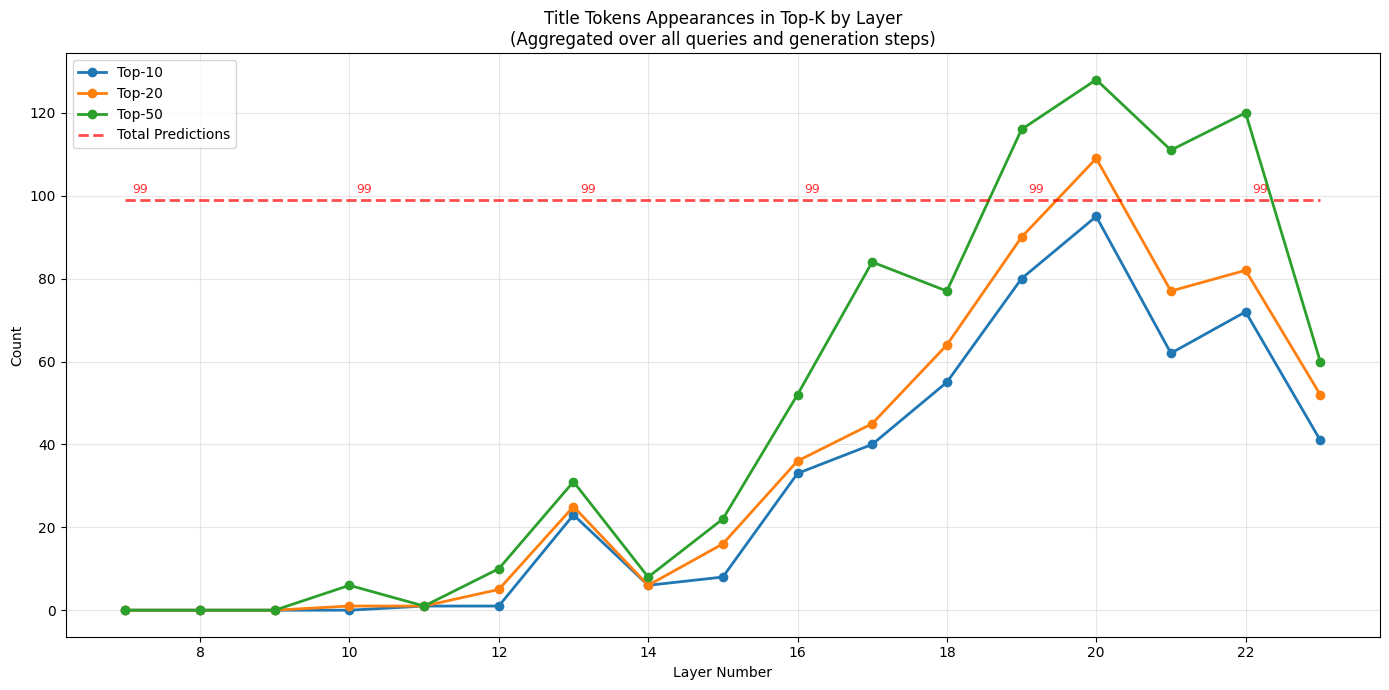

LAYER-BY-LAYER TITLE TOKENS COUNTS:
Layer | Top-10 | Top-20 | Top-50 | Total Predictions |
------|--------|--------|--------|-------------------|
    7 |      0 |      0 |      0 |                99 |
    8 |      0 |      0 |      0 |                99 |
    9 |      0 |      0 |      0 |                99 |
   10 |      0 |      1 |      6 |                99 |
   11 |      1 |      1 |      1 |                99 |
   12 |      1 |      5 |     10 |                99 |
   13 |     23 |     25 |     31 |                99 |
   14 |      6 |      6 |      8 |                99 |
   15 |      8 |     16 |     22 |                99 |
   16 |     33 |     36 |     52 |                99 |
   17 |     40 |     45 |     84 |                99 |
   18 |     55 |     64 |     77 |                99 |
   19 |     80 |     90 |    116 |                99 |
   20 |     95 |    109 |    128 |                99 |
   21 |     62 |     77 |    111 |                99 |
   22 |     72 |     82 |    

In [15]:
# Analysis for title tokens in top-k metric
def analyze_title_tokens_by_layer(enhanced_analysis_data):
    """
    Count how many title tokens appear in top-k for each layer
    Aggregated over all queries and generation steps
    """
    
    results = {}
    
    # For each layer, count title token appearances across all top-k values
    for layer in range(7, model.cfg.n_layers):
        layer_key = f'layer_{layer}'
        results[layer] = {}
        
        for k in [10, 20, 50]:
            stat_key = f'top_{k}_title_tokens_ratio'
            
            if layer_key in enhanced_analysis_data['layer_stats'][stat_key]:
                ratios = enhanced_analysis_data['layer_stats'][stat_key][layer_key]
                # Convert ratios back to counts
                count = sum([ratio * k for ratio in ratios])  # Total count of title tokens
                total = len(ratios)   # Total predictions made
            else:
                count = 0
                total = 0
            
            results[layer][f'top_{k}'] = {
                'count': int(count),  # Convert to int for cleaner display
                'total': total
            }
    
    return results

# Run the title tokens analysis
title_tokens_layer_counts = analyze_title_tokens_by_layer(enhanced_analysis_data)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

layers = list(range(7, model.cfg.n_layers))

# Plot title tokens counts
for k in [10, 20, 50]:
    counts = [title_tokens_layer_counts[layer][f'top_{k}']['count'] for layer in layers]
    ax.plot(layers, counts, marker='o', linewidth=2, markersize=6, label=f'Top-{k}')

# Plot total predictions on the same scale
totals = [title_tokens_layer_counts[layer]['top_10']['total'] for layer in layers]  # Same for all k values
ax.plot(layers, totals, 'r--', linewidth=2, alpha=0.7, label='Total Predictions')

ax.set_xlabel('Layer Number')
ax.set_ylabel('Count')
ax.set_title('Title Tokens Appearances in Top-K by Layer\n(Aggregated over all queries and generation steps)')
ax.legend()
ax.grid(True, alpha=0.3)

# Add text annotations showing total predictions for some layers
for i, layer in enumerate(layers[::3]):  # Show every 3rd layer to avoid crowding
    total = title_tokens_layer_counts[layer]['top_10']['total']
    ax.annotate(f'{total}', 
                xy=(layer, total), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=9, 
                color='red', 
                alpha=0.8)

plt.tight_layout()
plt.show()

# Print summary table with totals
print("LAYER-BY-LAYER TITLE TOKENS COUNTS:")
print("Layer | Top-10 | Top-20 | Top-50 | Total Predictions |")
print("------|--------|--------|--------|-------------------|")

for layer in layers:
    top10_count = title_tokens_layer_counts[layer]['top_10']['count']
    top20_count = title_tokens_layer_counts[layer]['top_20']['count']
    top50_count = title_tokens_layer_counts[layer]['top_50']['count']
    total_preds = title_tokens_layer_counts[layer]['top_10']['total']
    
    print(f"{layer:5d} | {top10_count:6d} | {top20_count:6d} | {top50_count:6d} | {total_preds:17d} |")

# Overall totals for title tokens
print(f"\nOVERALL TITLE TOKENS TOTALS:")
for k in [10, 20, 50]:
    total_count = sum(title_tokens_layer_counts[layer][f'top_{k}']['count'] for layer in layers)
    total_predictions = sum(title_tokens_layer_counts[layer][f'top_{k}']['total'] for layer in layers)
    print(f"Top-{k}: {total_count:,} title token appearances out of {total_predictions:,} total predictions")

# Check if all layers have the same total predictions
all_totals = [title_tokens_layer_counts[layer]['top_10']['total'] for layer in layers]
if len(set(all_totals)) == 1:
    print(f"\nAll layers have the same number of predictions: {all_totals[0]}")
else:
    print(f"\nPredictions vary by layer - Min: {min(all_totals)}, Max: {max(all_totals)}")

# Compare with other metrics
print(f"\nCOMPARISON: ALL THREE METRICS")
print("Layer | Exact Top-10 | Semantic Top-10 | Title Tokens Top-10 | Exact Top-20 | Semantic Top-20 | Title Tokens Top-20 |")
print("------|--------------|-----------------|---------------------|--------------|-----------------|---------------------|")

for layer in layers:
    exact_10 = layer_counts[layer]['top_10']['count']
    semantic_10 = semantic_layer_counts[layer]['top_10']['count']
    title_10 = title_tokens_layer_counts[layer]['top_10']['count']
    exact_20 = layer_counts[layer]['top_20']['count']
    semantic_20 = semantic_layer_counts[layer]['top_20']['count']
    title_20 = title_tokens_layer_counts[layer]['top_20']['count']
    
    print(f"{layer:5d} | {exact_10:12d} | {semantic_10:15d} | {title_10:19d} | {exact_20:12d} | {semantic_20:15d} | {title_20:19d} |")

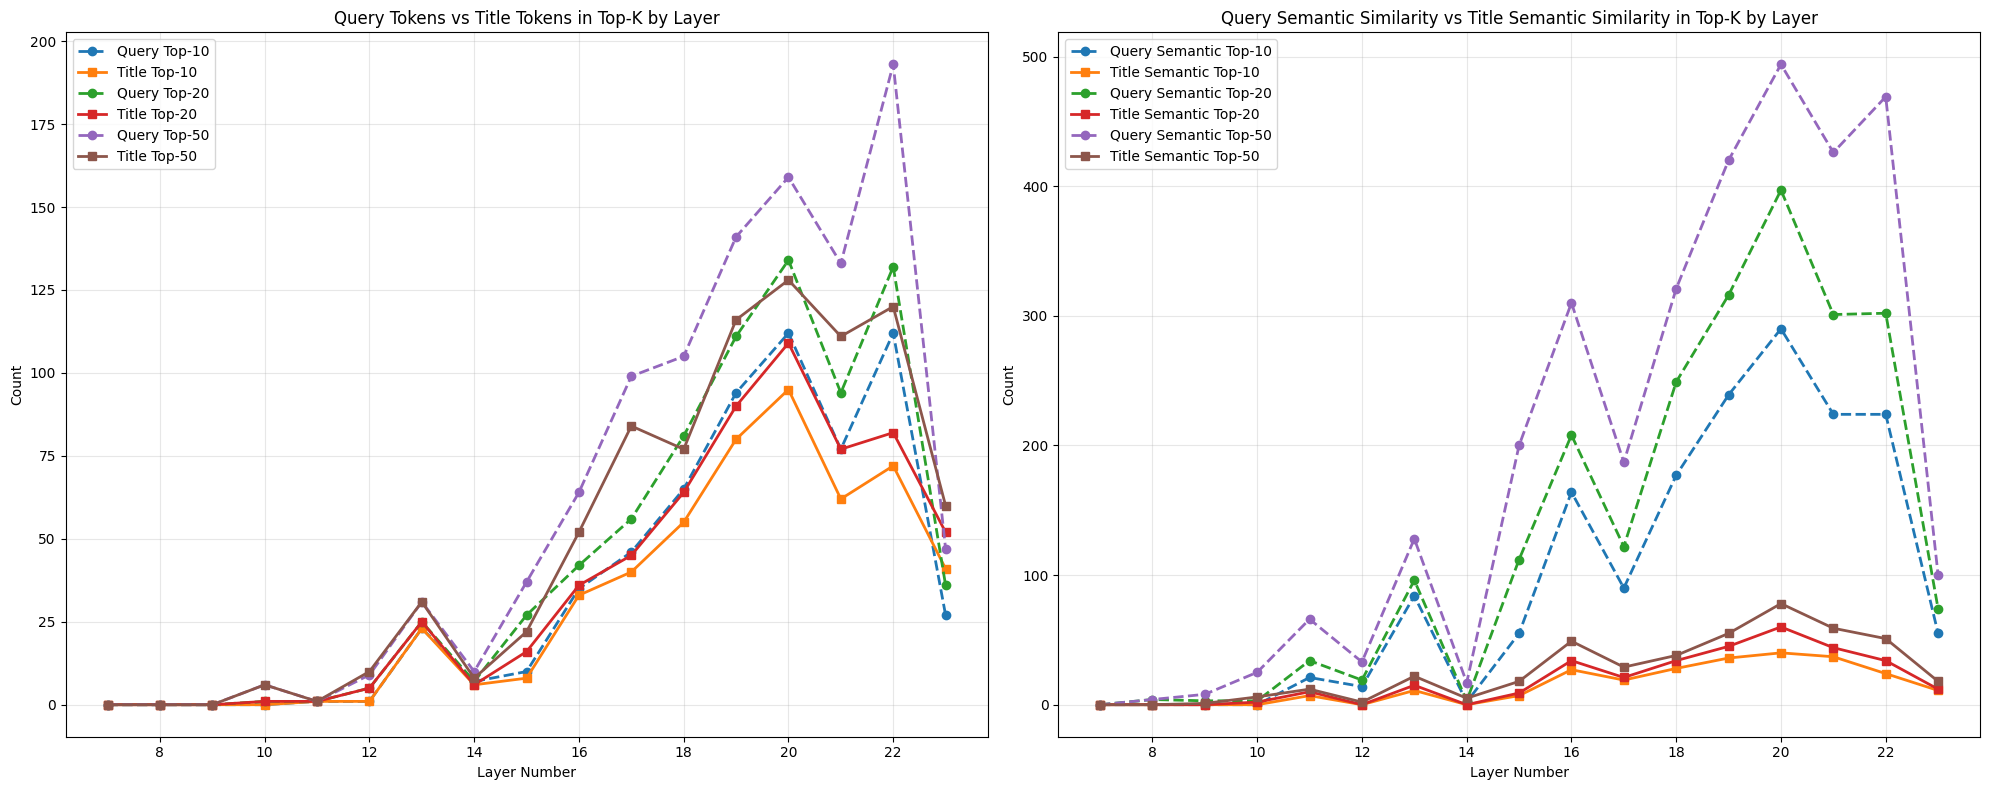

COMPREHENSIVE COMPARISON: QUERY vs TITLE TOKENS
Layer | Query T-10 | Title T-10 | Query S-10 | Title S-10 | Query T-20 | Title T-20 | Query S-20 | Title S-20 |
------|------------|------------|------------|------------|------------|------------|------------|------------|
    7 |          0 |          0 |          0 |          0 |          0 |          0 |          0 |          0 |
    8 |          0 |          0 |          0 |          0 |          0 |          0 |          4 |          0 |
    9 |          0 |          0 |          0 |          0 |          0 |          0 |          3 |          0 |
   10 |          0 |          0 |          0 |          0 |          1 |          1 |          3 |          2 |
   11 |          1 |          1 |         21 |          7 |          1 |          1 |         34 |         10 |
   12 |          1 |          1 |         14 |          0 |          5 |          5 |         19 |          0 |
   13 |         23 |         23 |         84 |         1

In [16]:
# Analysis for query tokens in top-k metric
def analyze_query_tokens_by_layer(enhanced_analysis_data):
    """
    Count how many query tokens appear in top-k for each layer
    Aggregated over all queries and generation steps
    """
    
    results = {}
    
    # For each layer, count query token appearances across all top-k values
    for layer in range(7, model.cfg.n_layers):
        layer_key = f'layer_{layer}'
        results[layer] = {}
        
        for k in [10, 20, 50]:
            stat_key = f'top_{k}_query_tokens_ratio'
            
            if layer_key in enhanced_analysis_data['layer_stats'][stat_key]:
                ratios = enhanced_analysis_data['layer_stats'][stat_key][layer_key]
                # Convert ratios back to counts
                count = sum([ratio * k for ratio in ratios])  # Total count of query tokens
                total = len(ratios)   # Total predictions made
            else:
                count = 0
                total = 0
            
            results[layer][f'top_{k}'] = {
                'count': int(count),  # Convert to int for cleaner display
                'total': total
            }
    
    return results

# Analysis for query semantic similarity
def analyze_query_semantic_similarity_by_layer(enhanced_analysis_data):
    """
    Count how many semantically similar query tokens appear in top-k for each layer
    Aggregated over all queries and generation steps
    """
    
    results = {}
    
    # For each layer, count query semantic matches across all top-k values
    for layer in range(7, model.cfg.n_layers):
        layer_key = f'layer_{layer}'
        results[layer] = {}
        
        for k in [10, 20, 50]:
            stat_key = f'top_{k}_query_semantic_matches_ratio'
            
            if layer_key in enhanced_analysis_data['layer_stats'][stat_key]:
                ratios = enhanced_analysis_data['layer_stats'][stat_key][layer_key]
                # Convert ratios back to counts
                count = sum([ratio * k for ratio in ratios])  # Total count of query semantic matches
                total = len(ratios)   # Total predictions made
            else:
                count = 0
                total = 0
            
            results[layer][f'top_{k}'] = {
                'count': int(count),  # Convert to int for cleaner display
                'total': total
            }
    
    return results

# Run the query token analyses
query_tokens_layer_counts = analyze_query_tokens_by_layer(enhanced_analysis_data)
query_semantic_layer_counts = analyze_query_semantic_similarity_by_layer(enhanced_analysis_data)

# Create comprehensive comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

layers = list(range(7, model.cfg.n_layers))

# Plot 1: Query tokens vs Title tokens
for k in [10, 20, 50]:
    query_counts = [query_tokens_layer_counts[layer][f'top_{k}']['count'] for layer in layers]
    title_counts = [title_tokens_layer_counts[layer][f'top_{k}']['count'] for layer in layers]
    
    ax1.plot(layers, query_counts, marker='o', linewidth=2, markersize=6, label=f'Query Top-{k}', linestyle='--')
    ax1.plot(layers, title_counts, marker='s', linewidth=2, markersize=6, label=f'Title Top-{k}', linestyle='-')

ax1.set_xlabel('Layer Number')
ax1.set_ylabel('Count')
ax1.set_title('Query Tokens vs Title Tokens in Top-K by Layer')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Query semantic similarity vs Title semantic similarity
for k in [10, 20, 50]:
    query_semantic_counts = [query_semantic_layer_counts[layer][f'top_{k}']['count'] for layer in layers]
    title_semantic_counts = [semantic_layer_counts[layer][f'top_{k}']['count'] for layer in layers]
    
    ax2.plot(layers, query_semantic_counts, marker='o', linewidth=2, markersize=6, label=f'Query Semantic Top-{k}', linestyle='--')
    ax2.plot(layers, title_semantic_counts, marker='s', linewidth=2, markersize=6, label=f'Title Semantic Top-{k}', linestyle='-')

ax2.set_xlabel('Layer Number')
ax2.set_ylabel('Count')
ax2.set_title('Query Semantic Similarity vs Title Semantic Similarity in Top-K by Layer')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comprehensive comparison table
print("COMPREHENSIVE COMPARISON: QUERY vs TITLE TOKENS")
print("Layer | Query T-10 | Title T-10 | Query S-10 | Title S-10 | Query T-20 | Title T-20 | Query S-20 | Title S-20 |")
print("------|------------|------------|------------|------------|------------|------------|------------|------------|")

for layer in layers:
    query_t10 = query_tokens_layer_counts[layer]['top_10']['count']
    title_t10 = title_tokens_layer_counts[layer]['top_10']['count']
    query_s10 = query_semantic_layer_counts[layer]['top_10']['count']
    title_s10 = semantic_layer_counts[layer]['top_10']['count']
    query_t20 = query_tokens_layer_counts[layer]['top_20']['count']
    title_t20 = title_tokens_layer_counts[layer]['top_20']['count']
    query_s20 = query_semantic_layer_counts[layer]['top_20']['count']
    title_s20 = semantic_layer_counts[layer]['top_20']['count']
    
    print(f"{layer:5d} | {query_t10:10d} | {title_t10:10d} | {query_s10:10d} | {title_s10:10d} | {query_t20:10d} | {title_t20:10d} | {query_s20:10d} | {title_s20:10d} |")

# Overall summary
print(f"\nOVERALL SUMMARY:")
print("Metric | Query Top-10 | Title Top-10 | Query Top-20 | Title Top-20 | Query Top-50 | Title Top-50 |")
print("-------|--------------|--------------|--------------|--------------|--------------|--------------|")

for metric_name, query_data, title_data in [
    ("Exact Tokens", query_tokens_layer_counts, title_tokens_layer_counts),
    ("Semantic Sim", query_semantic_layer_counts, semantic_layer_counts)
]:
    q10 = sum(query_data[layer]['top_10']['count'] for layer in layers)
    t10 = sum(title_data[layer]['top_10']['count'] for layer in layers)
    q20 = sum(query_data[layer]['top_20']['count'] for layer in layers)
    t20 = sum(title_data[layer]['top_20']['count'] for layer in layers)
    q50 = sum(query_data[layer]['top_50']['count'] for layer in layers)
    t50 = sum(title_data[layer]['top_50']['count'] for layer in layers)
    
    print(f"{metric_name:11s} | {q10:12,} | {t10:12,} | {q20:12,} | {t20:12,} | {q50:12,} | {t50:12,} |")